In [1]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Niuzong', 'Xiaobing', 'Mazong', 'Student', 'Teacher', 'Boss', 'Xiaoxue', 'Kage', 'is']
 词汇到索引的字典： {'Niuzong': 0, 'Xiaobing': 1, 'Mazong': 2, 'Student': 3, 'Teacher': 4, 'Boss': 5, 'Xiaoxue': 6, 'Kage': 7, 'is': 8}
 索引到词汇的字典： {0: 'Niuzong', 1: 'Xiaobing', 2: 'Mazong', 3: 'Student', 4: 'Teacher', 5: 'Boss', 6: 'Xiaoxue', 7: 'Kage', 8: 'is'}
 词汇表大小： 9


In [2]:
# 生成 Skip-Gram 训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = [] # 初始化数据
    for sentence in sentences: # 遍历句子
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻的单词，将当前单词前后各 N 个单词作为相邻单词
            for neighbor in sentence[max(idx - window_size, 0): 
                        min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前单词本身
                    # 将相邻单词与当前单词作为一组训练数据
                    # data.append((neighbor, word))
                    data.append((word, neighbor))
    return data
# 使用函数创建 Skip-Gram 训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印未编码的 Skip-Gram 数据样例（前 3 个）
print("Skip-Gram 数据样例（未编码）：", skipgram_data[:10])

Skip-Gram 数据样例（未编码）： [('Kage', 'is'), ('Kage', 'Teacher'), ('is', 'Kage'), ('is', 'Teacher'), ('Teacher', 'Kage'), ('Teacher', 'is'), ('Mazong', 'is'), ('Mazong', 'Boss'), ('is', 'Mazong'), ('is', 'Boss')]


In [3]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):    
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量  
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))
# 展示编码后的 Skip-Gram 训练数据样例
print("Skip-Gram数据样例（已编码）：", [(one_hot_encoding(target, word_to_idx), 
                               word_to_idx[context]) for context, target in skipgram_data[:3]])

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.])
Skip-Gram数据样例（已编码）： [(tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 7), (tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]), 7), (tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 8)]


In [4]:
# 定义 Skip-Gram 类
import torch.nn as nn # 导入 neural network
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入层大小（维度）的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)  
        # 从嵌入层大小（维度）到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)  
    def forward(self, X): # 前向传播的方式，X 形状为 (batch_size, voc_size)      
         # 通过隐藏层，hidden 形状为 (batch_size, embedding_size)
            hidden = self.input_to_hidden(X) 
            # 通过输出层，output_layer 形状为 (batch_size, voc_size)
            output = self.hidden_to_output(hidden)  
            return output    
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
skipgram_model = SkipGram(voc_size, embedding_size)  # 实例化 Skip-Gram 模型
print("Skip-Gram 模型：", skipgram_model)

Skip-Gram 模型： SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.171120345592499
Epoch: 200, Loss: 2.1314221342404682
Epoch: 200, Loss: 2.1314221342404682
Epoch: 300, Loss: 2.0822148164113363
Epoch: 300, Loss: 2.0822148164113363
Epoch: 400, Loss: 2.0243545293807985
Epoch: 400, Loss: 2.0243545293807985
Epoch: 500, Loss: 1.9667811830838522
Epoch: 500, Loss: 1.9667811830838522
Epoch: 600, Loss: 1.9198432246843973
Epoch: 600, Loss: 1.9198432246843973
Epoch: 700, Loss: 1.8858144462108613
Epoch: 700, Loss: 1.8858144462108613
Epoch: 800, Loss: 1.8609609146912893
Epoch: 800, Loss: 1.8609609146912893
Epoch: 900, Loss: 1.8411567509174347
Epoch: 900, Loss: 1.8411567509174347
Epoch: 1000, Loss: 1.8237266540527344
Epoch: 1000, Loss: 1.8237266540527344


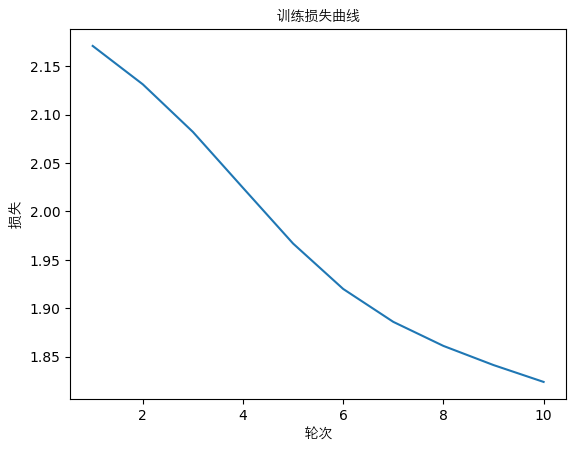

In [5]:
# 训练 Skip-Gram 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)  
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    # for context, target in skipgram_data:   
    for center_word, context in skipgram_data:     
        X = one_hot_encoding(center_word, word_to_idx).float().unsqueeze(0) # 将中心词转换为 One-Hot 向量  
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long) # 将周围词转换为索引值 
        y_pred = skipgram_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(skipgram_data)}")  
      loss_values.append(loss_sum / len(skipgram_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
from matplotlib.font_manager import FontProperties

# 为 macOS 设置中文字体
font_path = "/System/Library/Fonts/Hiragino Sans GB.ttc"
font_prop = FontProperties(fname=font_path)

plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ', fontproperties=font_prop) # 图题
plt.xlabel(' 轮次 ', fontproperties=font_prop) # X 轴 Label
plt.ylabel(' 损失 ', fontproperties=font_prop) # Y 轴 Label
plt.show() # 显示图

In [6]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {skipgram_model.input_to_hidden.weight[:,idx].detach().numpy()}")

Skip-Gram 词嵌入：
Niuzong: [ 0.65404516 -0.3249633 ]
Xiaobing: [-0.01977792 -0.7096    ]
Mazong: [ 0.32540035 -0.49588424]
Student: [ 0.97594374 -0.7104866 ]
Teacher: [ 0.03072012 -0.83722955]
Boss: [ 0.12160374 -0.8020906 ]
Xiaoxue: [-0.0852195  -0.66129386]
Kage: [ 0.31632045 -0.8859241 ]
is: [-0.26477826  0.8416911 ]


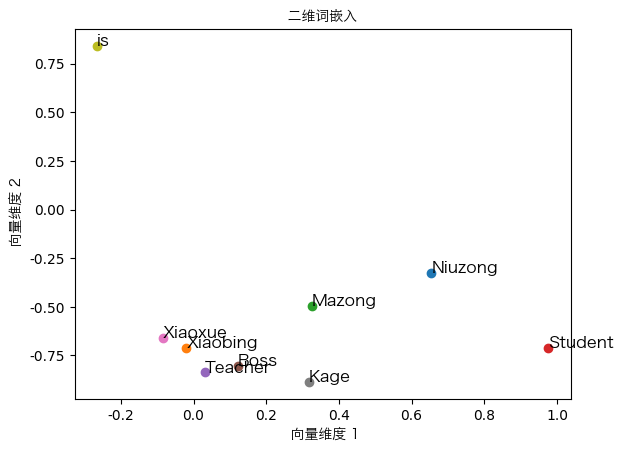

In [7]:
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = skipgram_model.input_to_hidden.weight[:,idx].detach().numpy() 
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontproperties=font_prop, fontsize=12) # 点旁添加单词标签
plt.title(' 二维词嵌入 ', fontproperties=font_prop) # 图题
plt.xlabel(' 向量维度 1', fontproperties=font_prop) # X 轴 Label
plt.ylabel(' 向量维度 2', fontproperties=font_prop) # Y 轴 Label
plt.show() # 显示图